# Efficient Gaussian Random Field Inference on Graphs - Regression Task on Traffic Dataset

This notebook contains the following:

1. Showing the baseline performance using the exact diffusion kernel.
2. Showing the similar level performance using Product of Feature Matrices (PoFM) kernel, compared across the parameter 'max_expansion' which determines the order of the approximation.
3. Showing the convergence of the GRF to the PoFM kernel for 'max_expansion = 5'
4. (Opt) Showing the performance of grf kernel with arbitrary modulation function. 

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import scipy.special
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
from tqdm import tqdm

import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

from efficient_graph_gp.graph_kernels import get_normalized_laplacian
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel
from utils import compute_fro
from traffic_utils.preprocessing import load_PEMS
from traffic_utils.plotting import plot_PEMS

2025-11-18 06:18:50.205122: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 06:18:50.218571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763446730.232456 4131246 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763446730.237088 4131246 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763446730.247790 4131246 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
os.chdir('../..')

In [3]:
!ls

algorithms		   experiments_sparse  requirements.txt
Archive			   graph_bo	       setup.py
data			   presentations       svgp_loss_curve_500_steps.csv
efficient_graph_gp	   processed_data      utils.py
efficient_graph_gp_sparse  __pycache__	       venv
experiments_dense	   README.md


In [8]:
# Load and preprocess the PEMS dataset

np.random.seed(1111)
num_eigenpairs = 500
dataset = 'PeMS-Bay-new'
num_train = 250

G, data_train, data_test, data = load_PEMS(num_train=num_train)
x_train, y_train = data_train
x_test, y_test = data_test
x, y = data
orig_mean, orig_std = np.mean(y_train), np.std(y_train)
y_train = (y_train-orig_mean)/orig_std
y_test = (y_test-orig_mean)/orig_std

X_train = tf.convert_to_tensor(x_train)
X_full = tf.convert_to_tensor(x)
Y_train = tf.convert_to_tensor(y_train)

adjacency_matrix = nx.to_numpy_array(G)  # Converts to NumPy adjacency matrix
print(adjacency_matrix.shape)  # Check matrix size

/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_dense/traffic_dataset/traffic_utils/preprocessing.py:90: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  G = pickle.load(f)


epsg:4326
(1016, 1016)


In [9]:
N = X_train.shape[0] # Number of training observations
M = 150  # Number of inducing locations

kernel = GraphDiffusionKernel(
    adjacency_matrix=adjacency_matrix
)
Z = X_train[:M, :].numpy().copy()  # Initialize inducing locations to the first M inputs in the dataset

m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)

In [10]:
def svgp_training(X, Y, model, num_iterations=300, learning_rate=0.01):
    """
    Train SVGP model using Adam optimizer
    
    Args:
        X: Training inputs
        Y: Training outputs
        model: SVGP model to train
        num_iterations: Number of optimization iterations
        learning_rate: Learning rate for Adam optimizer
    
    Returns:
        model: Trained SVGP model
        losses: List of loss values during training
    """
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    
    @tf.function
    def optimization_step():
        with tf.GradientTape() as tape:
            loss = model.training_loss((X, Y))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss
    
    losses = []
    for i in tqdm(range(num_iterations), desc='Training SVGP'):
        loss = optimization_step()
        losses.append(loss.numpy())
        
        if i % 100 == 0:
            print(f"Iteration {i}: Loss = {loss.numpy():.4f}")
    
    return model, losses

def svgp_evaluate(model, x_test, y_test, orig_std):
    """
    Evaluate SVGP model on test data
    
    Args:
        model: Trained SVGP model
        x_test: Test inputs
        y_test: Test outputs (standardized)
        orig_std: Original standard deviation for denormalization
    
    Returns:
        rmse: Root mean squared error
        nlpd: Negative log predictive density
    """
    # Get predictions (includes observation noise)
    mean_y, var_y = model.predict_y(x_test)
    
    # Reshape predictions
    mean_y = tf.reshape(mean_y, [-1])
    var_y = tf.reshape(var_y, [-1])
    
    # Compute RMSE (denormalized)
    rmse = float(orig_std * tf.sqrt(tf.reduce_mean((y_test[:, 0] - mean_y) ** 2)))
    
    # Compute NLPD
    nlpd = -tf.reduce_sum(
        tfp.distributions.Normal(loc=mean_y, scale=tf.sqrt(var_y)).log_prob(y_test[:, 0])
    ).numpy()
    
    return rmse, nlpd

In [11]:
# Train the SVGP model
trained_model, losses = svgp_training(X_train, Y_train, m, num_iterations=500, learning_rate=0.01)

Training SVGP:   0%|          | 0/500 [00:00<?, ?it/s]

/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['Variable:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Training SVGP:   0%|          | 1/500 [00:04<34:29,  4.15s/it]

Iteration 0: Loss = 397.3428


Training SVGP:  20%|██        | 101/500 [01:32<05:53,  1.13it/s]

Iteration 100: Loss = 357.2483


Training SVGP:  40%|████      | 201/500 [03:01<04:25,  1.13it/s]

Iteration 200: Loss = 355.5962


Training SVGP:  60%|██████    | 301/500 [04:29<02:56,  1.13it/s]

Iteration 300: Loss = 355.1053


Training SVGP:  80%|████████  | 401/500 [05:58<01:27,  1.13it/s]

Iteration 400: Loss = 354.8440


Training SVGP: 100%|██████████| 500/500 [07:26<00:00,  1.12it/s]


In [12]:
loss_path = 'svgp_loss_curve_500_steps.csv'

# Save the loss curve to CSV
import pandas as pd
loss_df = pd.DataFrame({'iteration': range(len(losses)), 'loss': losses})
loss_df.to_csv(loss_path, index=False)
print(f"Loss curve saved to {loss_path}")

Loss curve saved to svgp_loss_curve_500_steps.csv


In [13]:
print_summary(trained_model)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value                                                │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SVGP.kernel.beta         │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 3.94452                                              │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.kernel.sigma_f      │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 0.45438422185084354                                  │
├─────────

In [14]:
rmse, nlpd = svgp_evaluate(trained_model, x_test=x_test, y_test=y_test, orig_std=orig_std)
print(f"RMSE = {rmse}")
print(f"NLPD = {nlpd}")

RMSE = 16.229222421043882
NLPD = 102.18519052527951


In [2]:
!ls

archive			   README.md
bayes_opt.ipynb		   results
data			   results_0917
deliverables_GNN.ipynb	   results_1116
deliverables.ipynb	   results_1117
deliverables_SVGP.ipynb    spectral_analysis.ipynb
GRF_traffic_summary.png    traffic_experiment.py
importance_sampling.ipynb  traffic_utils
logs			   visualize_traffic_results.ipynb


Loaded 500 loss values from svgp_loss_curve_500_steps.csv


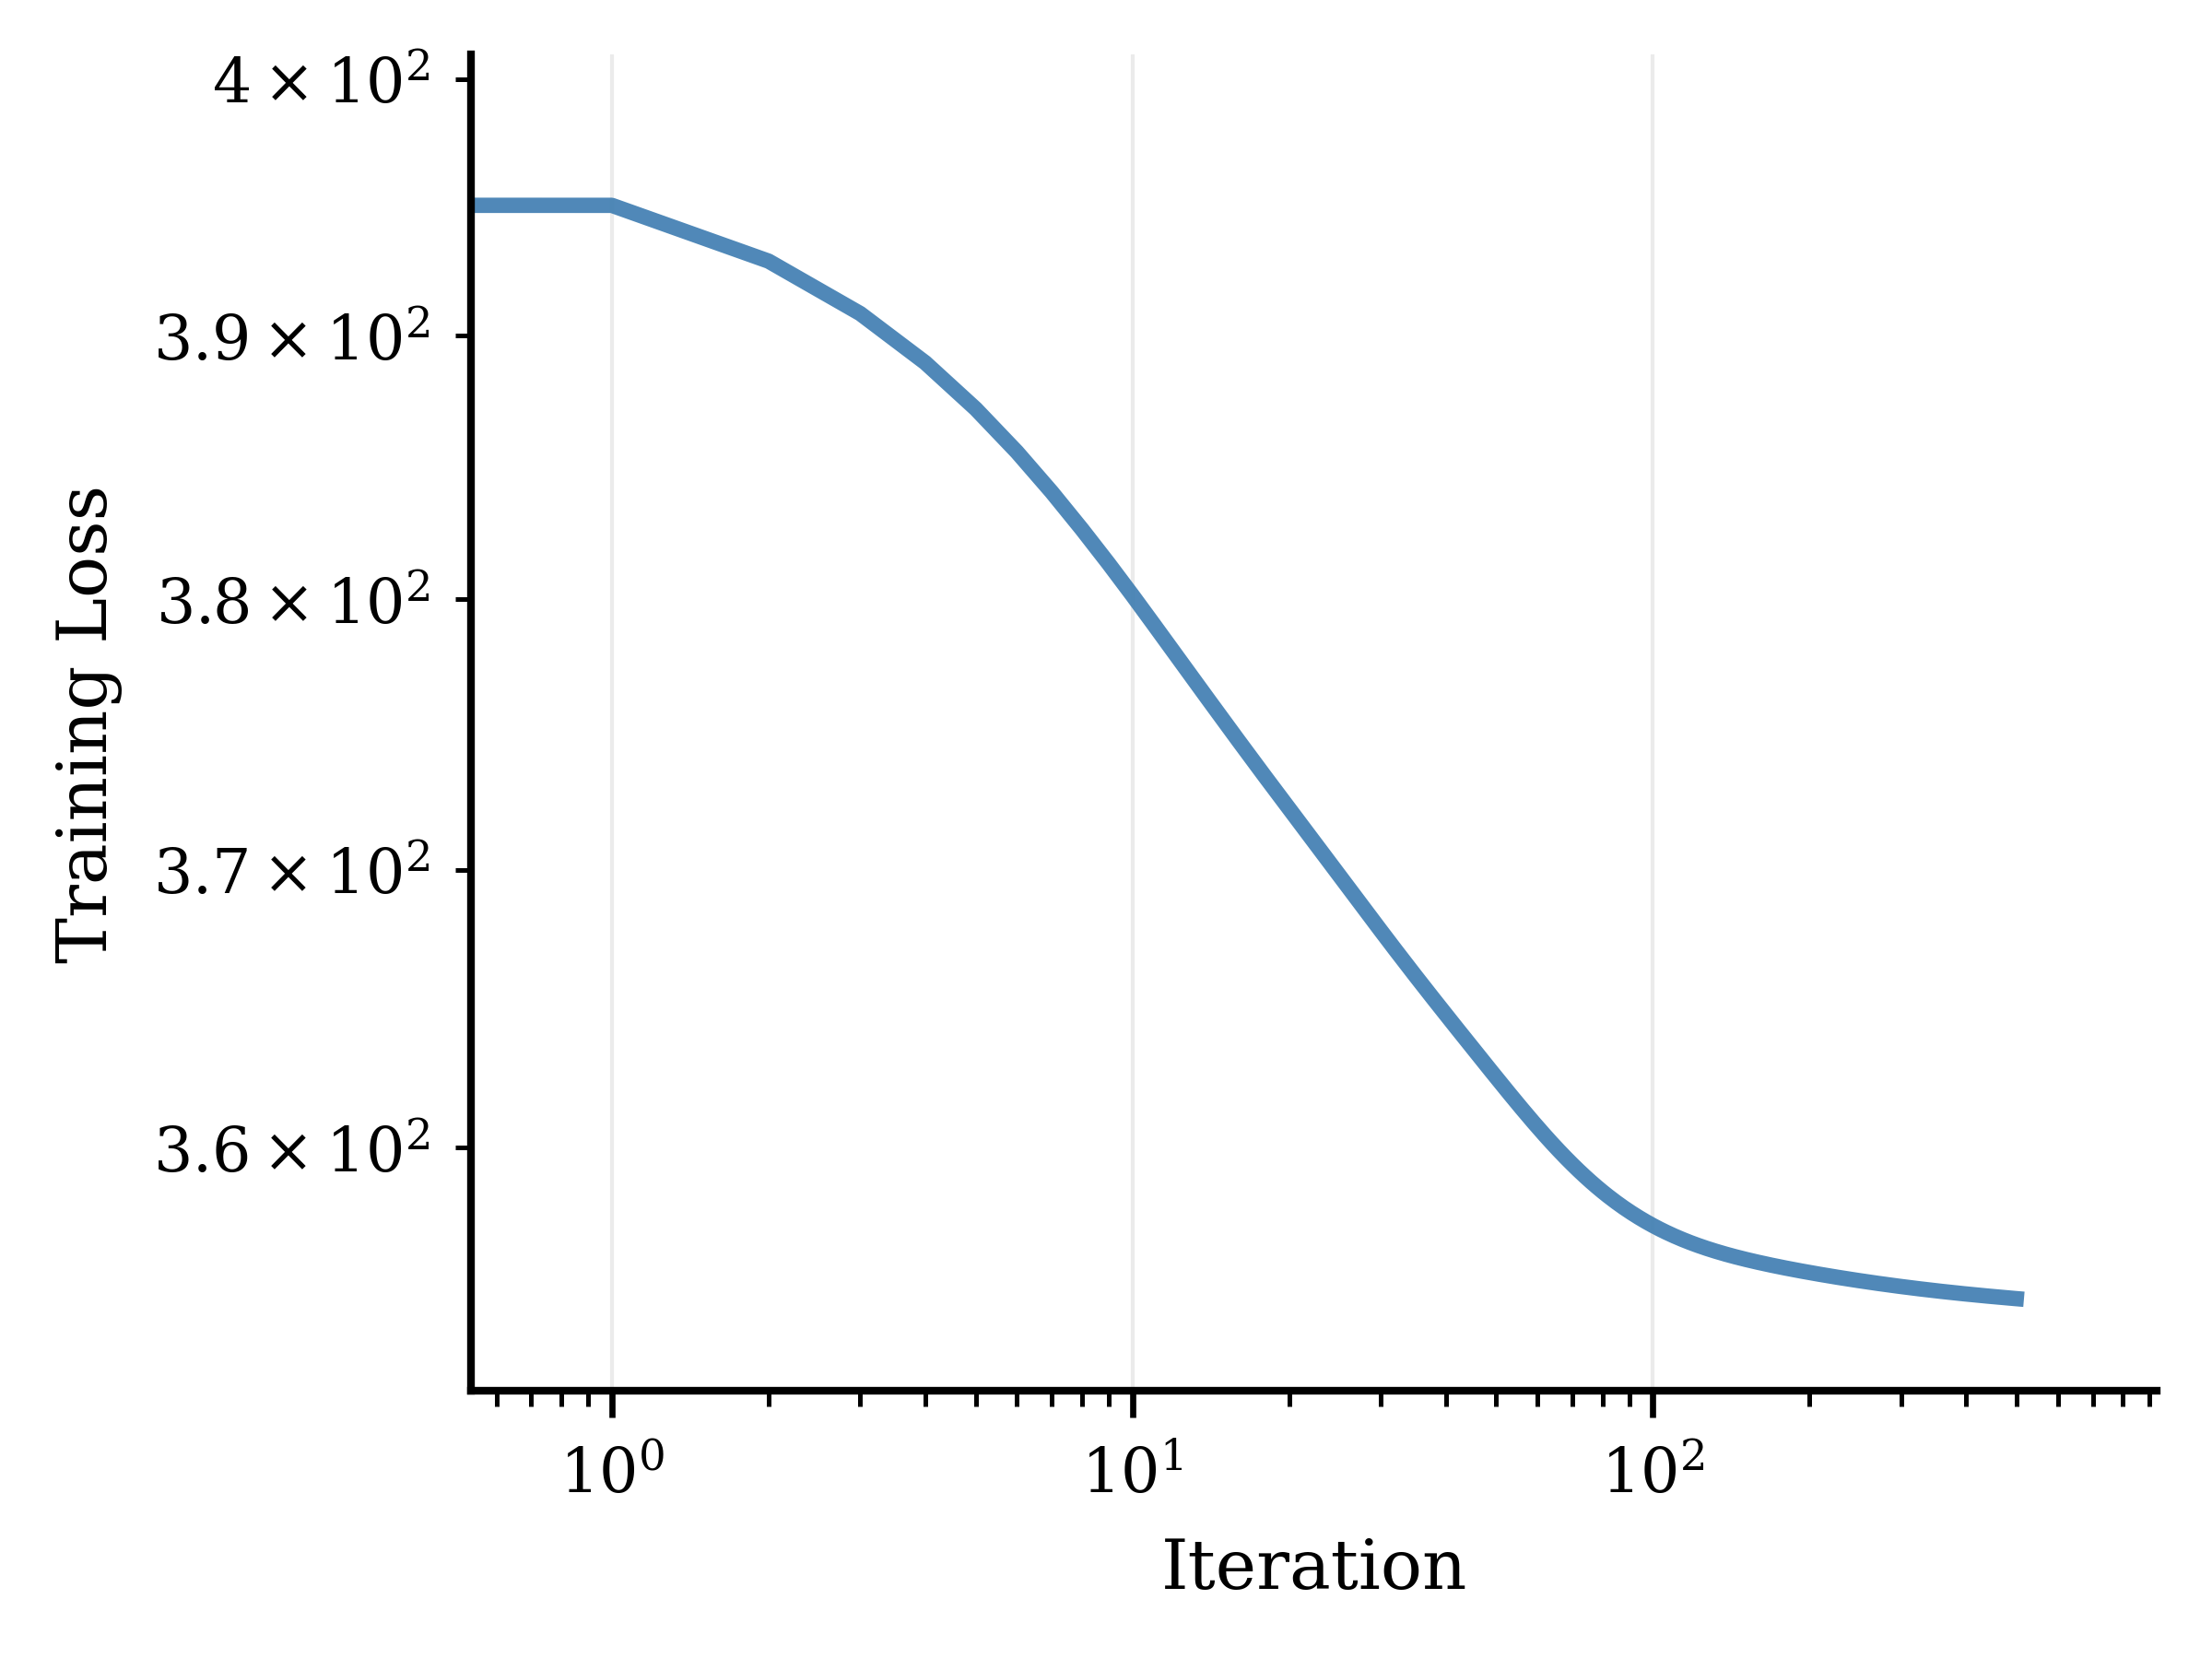

Final loss: 354.6821
Initial loss: 397.3428
Loss reduction: 42.6608


In [ ]:
# Load the loss curve data from CSV
import pandas as pd
import sys
import os
from matplotlib import pyplot as plt
project_root = os.path.abspath("../..")
os.chdir('../..')
sys.path.append(project_root)


loss_path = 'svgp_loss_curve_500_steps.csv'
loss_df = pd.read_csv(loss_path)
losses = loss_df['loss'].values
print(f"Loaded {len(losses)} loss values from {loss_path}")

# Plot the loss curve with publication-style formatting
import matplotlib as mpl
mpl.rcParams.update({
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],
    "font.size": 9,
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.linewidth": 1.0,
    "grid.linewidth": 0.5,
    "grid.alpha": 0.25,
    "axes.axisbelow": True,
    "axes.edgecolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
})

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(range(len(losses)), losses, linewidth=6, color='steelblue', alpha=0.95)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Training Loss')
ax.grid(True, which='major', axis='both')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.margins(x=0.10, y=0.08)
plt.tight_layout(pad=0.8)
plt.show()

print(f"Final loss: {losses[-1]:.4f}")
print(f"Initial loss: {losses[0]:.4f}")
print(f"Loss reduction: {losses[0] - losses[-1]:.4f}")